# Anomaly Detection with Generative Adveserial Networks

This notebook shows a simple example with anomaly detection with GANs. 

It uses a simple model where Generator $G(z)$ tries to fool Discirminitor with samples whose seed is based on a random value $z$. 

Discriminator is fed with either fake samples $G(z)$ and real data $X$ and its goal is to maximize its ability to distinguish between real and fake samples

Minimax Loss https://developers.google.com/machine-learning/gan/loss

The GAN implementation is inspired by https://github.com/lyeoni/pytorch-mnist-GAN/blob/master/pytorch-mnist-GAN.ipynb



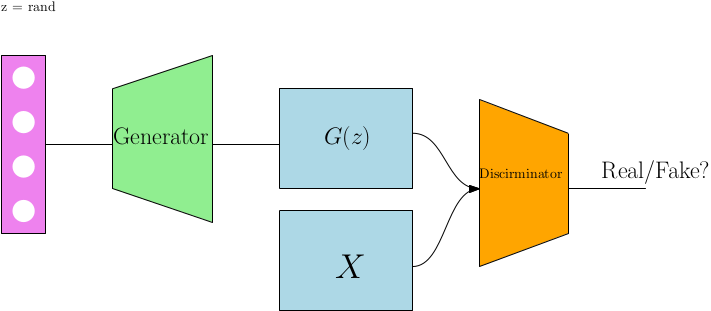

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt 



bs = 100
n_epoch = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

toimg = lambda x : x.reshape(28,28).detach().cpu().numpy()

!wget https://www.dropbox.com/s/iqi5lpeb5dd1amp/gan_trained_model_200epoch.torch

--2022-09-12 13:42:11--  https://www.dropbox.com/s/iqi5lpeb5dd1amp/gan_trained_model_200epoch.torch
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/iqi5lpeb5dd1amp/gan_trained_model_200epoch.torch [following]
--2022-09-12 13:42:12--  https://www.dropbox.com/s/raw/iqi5lpeb5dd1amp/gan_trained_model_200epoch.torch
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3eae86c557c01f54b621f0c8dc.dl.dropboxusercontent.com/cd/0/inline/BsyOK2P1LaTkNMqkjZTGgMctyVyf_Hes3AfC0lhMFMYX6o_qUgGkURC29dxRxrGnb3jZKsn1H4kGeJhGveLVjjbA-xCuhak4nKLabIiL4hg_4ykMef-7zG5LtFvqYN4J_bdVHPnzEdgs4GUlI6f3Fpsj77sJbO-qwAoKHldEEfyT8w/file# [following]
--2022-09-12 13:42:12--  https://uc3eae86c557c01f54b621f0c8dc.dl.dropboxusercontent.com/cd/0/inline/BsyOK2P1LaTkNMqkjZTG

## Loading Datasets

In [ ]:
# MNIST Dataset & EMNIST dataset
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5),(0.5,))])


train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.KMNIST(root='./kmnist_data/', train=False, transform=transform, download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting ./kmnist_data/KMNIST/raw/train-images-idx3-ubyte.gz to ./kmnist_data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting ./kmnist_data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./kmnist_data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting ./kmnist_data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./kmnist_data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting ./kmnist_data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./kmnist_data/KMNIST/raw



## Generator and Discriminator Classes

In [ ]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
train = False
if train:
    for epoch in range(1, n_epoch+1):           
        D_losses, G_losses = [], []
        for batch_idx, (x, _) in enumerate(train_loader):
            D_losses.append(D_train(x))
            G_losses.append(G_train(x))

        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
                (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))
        
    torch.save({'G' : G.state_dict(), 'D' : D.state_dict()}, 'trained_model.torch')
else:
    weights = torch.load('./gan_trained_model_200epoch.torch')
    G.load_state_dict(weights['G'])
    D.load_state_dict(weights['D'])
    G = G.to(device)
    D = D.to(device)

In [ ]:

def anogan_z(x,G,D,l = 0.1, z0 = None, lr = 0.005, epochs = 2000):
    if z0 is None:
        z0 = torch.randn((1,z_dim)).to(device)

    z = torch.autograd.Variable(z0,requires_grad = True).to(device)
    optimizer = optim.Adam([z], lr = lr)
    losses = []
    sigma = torch.tensor([[1.0]]).to(device)
    for epoch in range(epochs):
        g = G(z)
        loss = (1-l) * F.mse_loss(x,g) + l * F.binary_cross_entropy(D(g),sigma)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return z, g, losses

  0%|          | 0/10 [00:00<?, ?it/s]

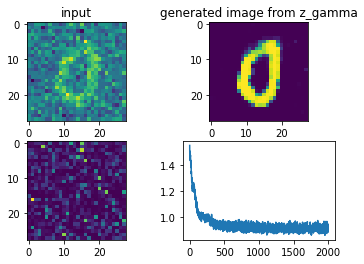

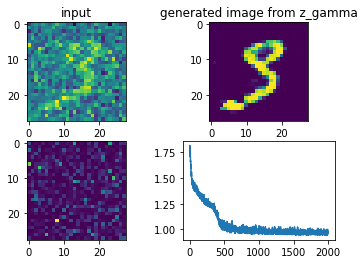

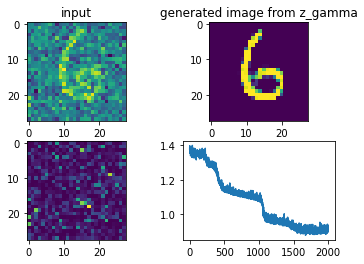

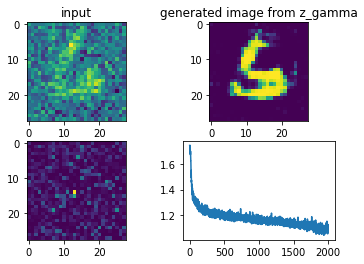

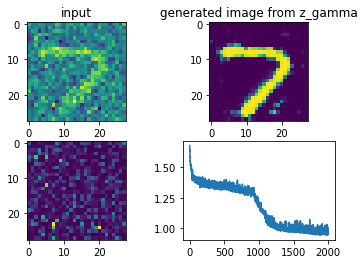

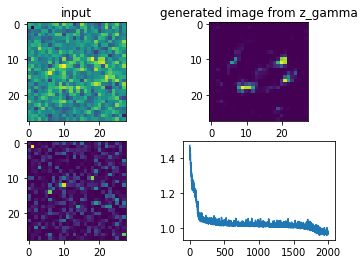

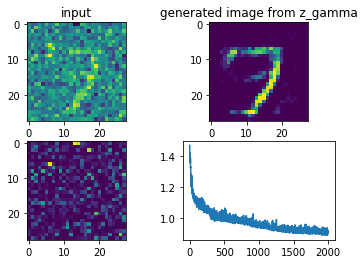

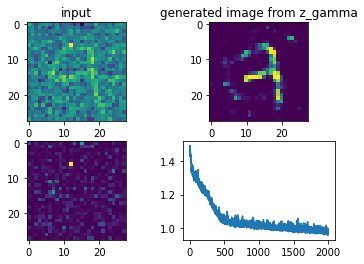

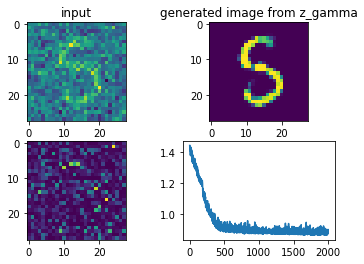

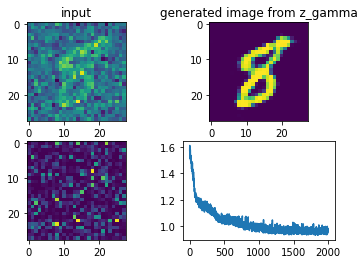

In [ ]:
from tqdm.autonotebook import tqdm
batch = next(iter(train_loader))[0]
sp = False # salt and pepper noise
score = []
for i in tqdm(range(10)):
    x = batch[i,0,...].reshape((1,-1)).to(device)
    if sp: 
        x[0,np.random.randint(0,784,10)] = 1.0
    else:
        x += torch.randn(*x.shape).to(device)
    z,g, loss = anogan_z(x,G,D)
    plt.subplot(221)
    plt.title('input')
    plt.imshow(toimg(x))
    plt.subplot(222)
    plt.title('generated image from z_gamma')
    plt.imshow(toimg(g))
    plt.subplot(223)
    plt.imshow(toimg((g - x)** 2))
    plt.subplot(224)
    plt.plot(loss)
    plt.show()
    score.append(loss)

  0%|          | 0/10 [00:00<?, ?it/s]

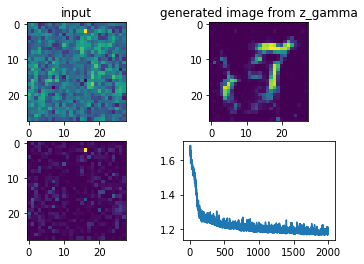

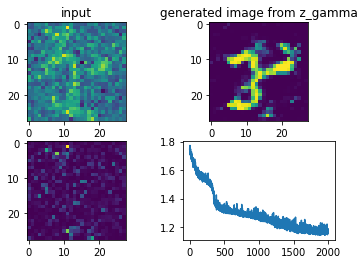

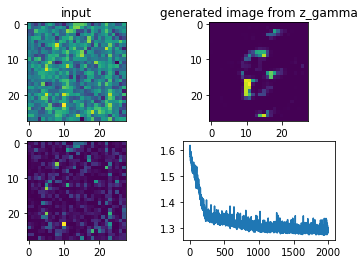

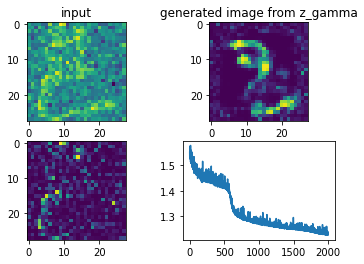

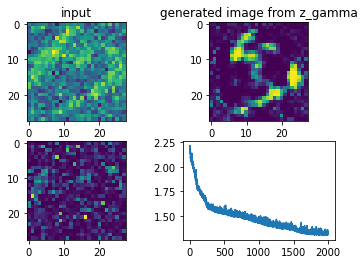

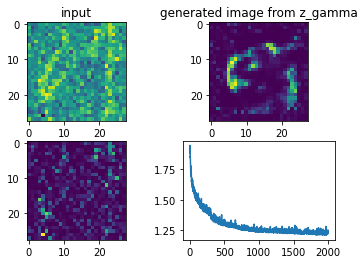

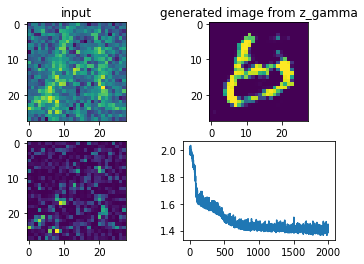

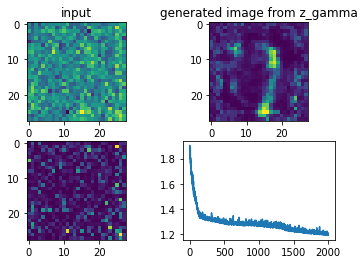

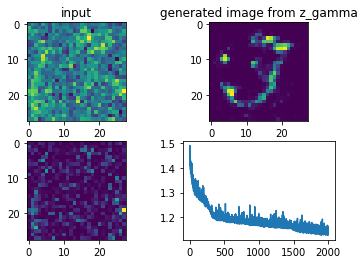

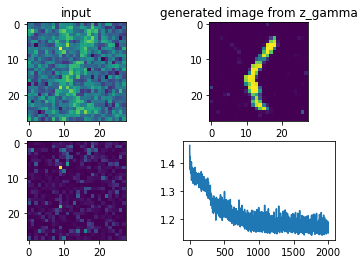

In [ ]:
batch = next(iter(test_loader))[0]
sp = False # salt and pepper noise
score_test = []
for i in tqdm(range(10)):
    x = batch[i,0,...].reshape((1,-1)).to(device)
    if sp: 
        x[0,np.random.randint(0,784,10)] = 1.0
    else:
        x += torch.randn(*x.shape).to(device)
    z,g, loss = anogan_z(x,G,D)
    plt.subplot(221)
    plt.title('input')
    plt.imshow(toimg(x))
    plt.subplot(222)
    plt.title('generated image from z_gamma')
    plt.imshow(toimg(g))
    plt.subplot(223)
    plt.imshow(toimg((g - x)** 2))
    plt.subplot(224)
    plt.plot(loss)
    plt.show()
    score_test.append(loss)

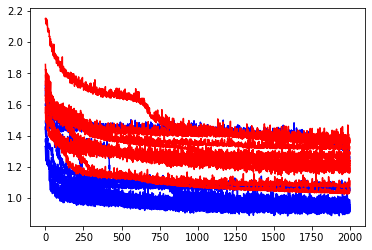

In [ ]:
for loss in score:
    plt.plot(loss,'b')
for loss in score_test:
    plt.plot(loss,'r')